<h1>Weight decay and Normal equation</h1>

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/PilotLeoYan/inside-deep-learning/blob/main/1-linear-regression/weight-decay-and-normal-equation.ipynb">
    <img src="../images/colab_logo.png" />Open in Google Colab</a>
  </td>
</table>

In this notebook we will visualize the effects of weight decay (or also called L2 regularizer) 
on the objective function $J$. When our model tries to minimize $J$, 
we see that the minimum of the function has moved from the minimum of the loss function. 
This means that the model is learning poorly to fit the training data, this can be useful to avoid overfitting.
This notebook will be useful as a bridge to notebook 
[1.4 - Interpretability and Generalization](1-4-interpretability-generalization.ipynb).

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

from platform import python_version
python_version()

'3.13.2'

In [2]:
import os
import sys

# Add the module path if running locally
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

try:
    # Try importing the module normally (for local execution)
    from tools.numpy_metrics import np_mape as mape
except ModuleNotFoundError:
    # If the module is not found, assume the code is running in Google Colab
    import subprocess

    repo_url = "https://raw.githubusercontent.com/PilotLeoYan/inside-deep-learning/main/tools/numpy_metrics.py"
    local_file = "numpy_metrics.py"

    # Download the missing file from GitHub
    subprocess.run(["wget", repo_url, "-O", local_file], check=True)

    # Import the module after downloading it
    import tools
    from numpy_metrics import np_mape as mape

# Dataset

## create dataset

In [3]:
M: int = 1_000 # number of samples
N: int = 1 # number of input features

X = np.random.randn(M, N)
True_W = np.array([[3.14]])
Y = X @ True_W + 1.0

X.shape, Y.shape

((1000, 1), (1000, 1))

# Linear Least Squares

## problem statement

Least squares
$$
\text{LS}(\mathbf{w}) = \frac{1}{2} \|\mathbf{Xw - y}\|^{2}_{2}
$$

In [4]:
def least_squares(w: np.ndarray) -> np.float64:
    return np.sum(np.square(X @ w - Y)) / 2

Problem to solve
$$
\min_{\mathbf{w}} \frac{1}{2} \|\mathbf{Xw - y}\|^{2}_{2}
$$

But, we are interested in finding $\mathbf{w}$ that minimizes the least squares.
Then, we are looking for
$$
\mathbf{w}^{*} = \argmin_{\mathbf{w}} \frac{1}{2} \|\mathbf{Xw - y}\|^{2}_{2}
$$

## normal equation

$$
\nabla_{\mathbf{w}}\text{LS} = \mathbf{X^{\top}} (\mathbf{Xw - y})
$$

If we equal it to 0 (zero vector) to find the minimum of least squares
$$
\nabla_{\mathbf{w}}\text{LS} = \mathbf{0} \\
\mathbf{X^{\top}} (\mathbf{Xw - y}) = \mathbf{0} \\
\mathbf{X^{\top}Xw - X^{\top}y = 0} \\
\mathbf{X^{\top}Xw} = \mathbf{X^{\top}y} \\
\mathbf{w} = \left(\mathbf{X^{\top}X}\right)^{-1}\mathbf{X^{\top}y}
$$

In [5]:
w_ls = np.linalg.inv(X.T @ X) @ X.T @ Y
w_ls.shape

(1, 1)

In [6]:
least_squares(w_ls)

np.float64(499.9323463691207)

In [7]:
w_ls

array([[3.15179259]])

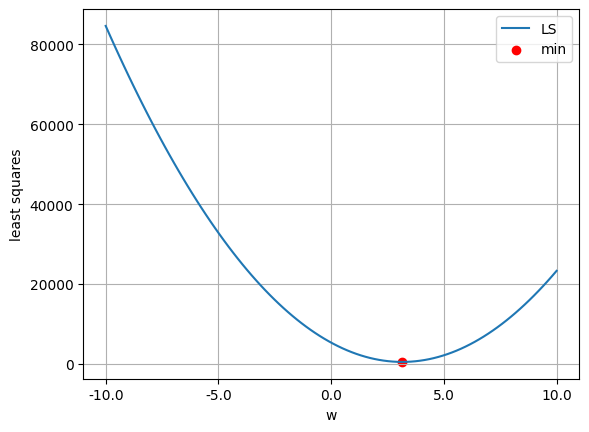

In [8]:
w_values = np.linspace(-10, 10, 100)
ls_values = np.array([least_squares(w.reshape(-1, 1)) for w in w_values])

plt.plot(w_values, ls_values, label='LS')
plt.scatter(w_ls.item(), least_squares(w_ls).item(), color='red', label='min')
plt.xticks(np.linspace(w_values[0], w_values[-1], 5))
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.1f}'))
plt.legend()
plt.xlabel('w')
plt.ylabel('least squares')
plt.grid(True)
plt.show()

## what happens if we use MSE loss?

Our typical MSE loss function is
$$
\begin{align*}
\text{MSE}(\mathbf{w}) &= \frac{1}{m} \sum_{i=1}^{m} \left(
    \mathbf{x}_{i,:} \mathbf{w - y}
\right)^{2} \\
&= \frac{1}{m} \|\mathbf{Xw - y}\|^{2}_{2} \\
&= \frac{2}{m} \text{LS}(\mathbf{w})
\end{align*}
$$

In [9]:
def mse_loss(w: np.ndarray) -> np.float64:
    return np.mean(np.square(X @ w - Y))

In [10]:
mape(
    mse_loss(w_ls),
    least_squares(w_ls) * 2 / M
).item()

0.0

Why does the normal least squares equation also minimize the MSE loss?
The gradient of MSE is
$$
\nabla_{\mathbf{w}}\text{MSE} = \frac{2}{m} \mathbf{X^{\top}(X^{\top}w - y)}
$$

$$
\nabla_{\mathbf{w}}\text{MSE} = \mathbf{0} \\
\frac{2}{m}\mathbf{X^{\top}} (\mathbf{Xw - y}) = \mathbf{0} \\
\frac{2}{m}\mathbf{X^{\top}Xw} - \frac{2}{m}\mathbf{X^{\top}y = 0} \\
\frac{2}{m}\mathbf{X^{\top}Xw} = \frac{2}{m}\mathbf{X^{\top}y} \\
\mathbf{w} = \left(\frac{2}{m} \mathbf{X^{\top}X}\right)^{-1} \frac{2}{m}\mathbf{X^{\top}y} \\
\mathbf{w} = \left(\frac{2}{m}\right)^{-1}\left(\mathbf{X^{\top}X}\right)^{-1} \frac{2}{m}\mathbf{X^{\top}y} \\
\mathbf{w} = \left(\mathbf{X^{\top}X}\right)^{-1} \mathbf{X^{\top}y} \\
$$

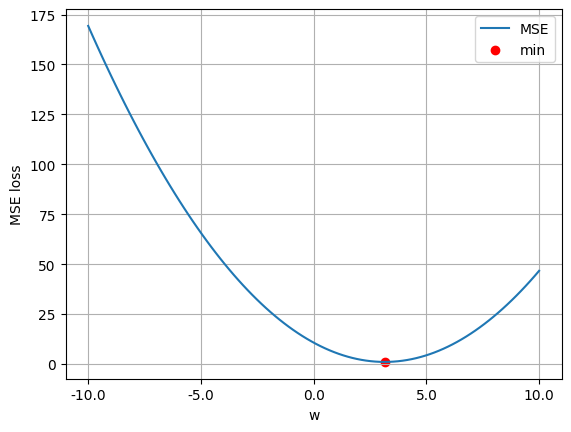

In [11]:
w_values = np.linspace(-10, 10, 100)
ls_values = np.array([mse_loss(w.reshape(-1, 1)) for w in w_values])

plt.plot(w_values, ls_values, label='MSE')
plt.scatter(w_ls.item(), mse_loss(w_ls).item(), color='red', label='min')
plt.xticks(np.linspace(w_values[0], w_values[-1], 5))
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.1f}'))
plt.legend()
plt.xlabel('w')
plt.ylabel('MSE loss')
plt.grid(True)
plt.show()

# LS + weight decay

## problem statement

Weight decay or L2 regularizer
$$
\ell_{2}(\mathbf{w}) = \frac{\lambda}{2}\|\mathbf{w}\|^{2}_{2}
$$
where $\lambda \in \mathbb{R}$ is a hyperparameter.

In [12]:
def weight_decay(lambd: float, w: np.ndarray) -> np.float64:
    return np.sum(np.square(w)) * lambd / 2

Objective function
$$
\begin{align*}
J_{\text{LS}}(\mathbf{w}) &= \text{LS}(\mathbf{w}) + \ell_{2}(\mathbf{w}) \\
&= \frac{1}{2} \|\mathbf{Xw - y}\|^{2}_{2}
+ \frac{\lambda_{1}}{2}\|\mathbf{w}\|^{2}_{2}
\end{align*}
$$

In [13]:
def objective_ls(lambd: float, w: np.ndarray) -> np.float64:
    return least_squares(w) + weight_decay(lambd, w)

Problem to solve
$$
\min_{\mathbf{w}} \left(
    \frac{1}{2} \|\mathbf{Xw - y}\|^{2}_{2}
    + \frac{\lambda_{1}}{2}\|\mathbf{w}\|^{2}_{2}
\right)
$$

We are looking
$$
\mathbf{w}^{*} = \argmin_{\mathbf{w}} \left(
    \frac{1}{2} \|\mathbf{Xw - y}\|^{2}_{2}
    + \frac{\lambda_{1}}{2}\|\mathbf{w}\|^{2}_{2}
\right)
$$

## closed form

$$
\nabla_{\mathbf{w}}J_{\text{LS}} = \mathbf{X^{\top}} (\mathbf{Xw - y})
+ \lambda_{1} \mathbf{w}
$$

$$
\nabla_{\mathbf{w}}J_{\text{LS}} =\mathbf{0} \\
\mathbf{X^{\top}} (\mathbf{Xw - y}) + \lambda_{1} \mathbf{w} = \mathbf{0} \\
\mathbf{X^{\top}Xw} + \lambda_{1}  \mathbf{w} - \mathbf{X^{\top}y} = \mathbf{0} \\
(\mathbf{X^{\top}X} + \lambda_{1}  \boldsymbol{I}) \mathbf{w} = \mathbf{X^{\top}y} \\
\mathbf{w} = (\mathbf{X^{\top}X} + \lambda_{1}  \boldsymbol{I})^{-1} \mathbf{X^{\top}y} \\
$$

In [14]:
LAMBDA: float = 1e3

In [15]:
w_ls_l2 = np.linalg.inv(X.T @ X + (LAMBDA * np.identity(N))) @ X.T @ Y
w_ls_l2.shape

(1, 1)

In [16]:
objective_ls(LAMBDA, w_ls_l2).item(), least_squares(w_ls_l2).item()

(2949.366950184064, 1741.4239736017662)

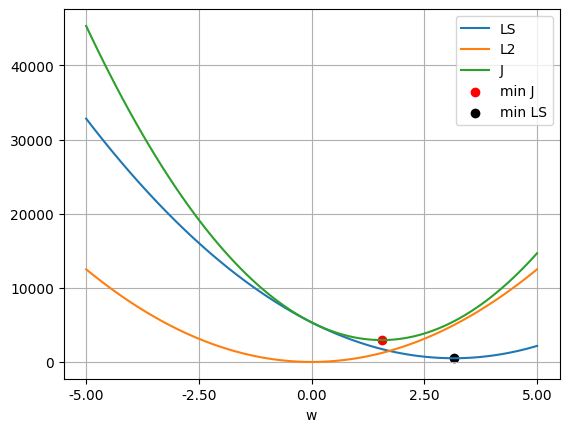

In [17]:
w_values = np.linspace(-5, 5, 100)
ls_values = np.array([least_squares(w.reshape(-1, 1)) for w in w_values])
wd_values = np.array([weight_decay(LAMBDA, w.reshape(-1, 1)) for w in w_values])
j_values = np.array([objective_ls(LAMBDA, w.reshape(-1, 1)) for w in w_values])

plt.plot(w_values, ls_values, label='LS')
plt.plot(w_values, wd_values, label='L2')
plt.plot(w_values, j_values, label='J')
plt.scatter(w_ls_l2.item(), objective_ls(LAMBDA, w_ls_l2).item(), color='red', label='min J')
plt.scatter(w_ls.item(), least_squares(w_ls).item(), color='black', label='min LS')
plt.xticks(np.linspace(w_values[0], w_values[-1], 5))
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.2f}'))
plt.legend()
plt.xlabel('w')
plt.grid(True)
plt.show()

# MSE + weight decay

## problem statement

Objective function
$$
J_{\text{MSE}}(\mathbf{w}) = \text{MSE}(\mathbf{w}) + \ell_{2}(\mathbf{w})
$$

In [18]:
def objective_mse(lambd: float, w: np.ndarray) -> np.float64:
    return mse_loss(w) + weight_decay(lambd, w)

Problem to solve
$$
\min_{\mathbf{w}} \left(
    \frac{1}{m} \|\mathbf{Xw - y}\|^{2}_{2}
    + \frac{\lambda_{2}}{2}\|\mathbf{w}\|^{2}_{2}
\right)
$$

We are looking
$$
\mathbf{w}^{*} = \argmin_{\mathbf{w}} \left(
    \frac{1}{m} \|\mathbf{Xw - y}\|^{2}_{2}
    + \frac{\lambda_{2}}{2}\|\mathbf{w}\|^{2}_{2}
\right)
$$

## closed form

$$
\nabla_{\mathbf{w}}J_{\text{MSE}} = \frac{2}{m}
\mathbf{X^{\top}} (\mathbf{Xw - y})
+ \lambda_{2} \mathbf{w}
$$

$$
\nabla_{\mathbf{w}}J_{\text{MSE}} =\mathbf{0} \\
\frac{2}{m} \mathbf{X^{\top}} (\mathbf{Xw - y}) + \lambda_{2} \mathbf{w} = \mathbf{0} \\
\frac{2}{m} \mathbf{X^{\top}Xw} + \lambda_{2} \mathbf{w} - \frac{2}{m} \mathbf{X^{\top}y} = \mathbf{0} \\
\left(\frac{2}{m} \mathbf{X^{\top}X} + \lambda_{2} \boldsymbol{I} \right) \mathbf{w} = \frac{2}{m} \mathbf{X^{\top}y} \\
\mathbf{w} = \frac{2}{m} \left(\frac{2}{m} \mathbf{X^{\top}X} + \lambda_{2} \boldsymbol{I} \right)^{-1} 
\mathbf{X^{\top}y} \\
$$

if we use the value of $\lambda_{1}$ used in least squares
$$
\lambda_{2} = \frac{2 \lambda_{1}}{m} 
$$
then, we get the following solution
$$
\mathbf{w} = \frac{2}{m} \left(\frac{2}{m} \mathbf{X^{\top}X} + \frac{2 \lambda_{1}}{m} \boldsymbol{I} \right)^{-1} 
\mathbf{X^{\top}y} \\
\mathbf{w} = \frac{2}{m} \left( \frac{2}{m}
    \left(
        \mathbf{X^{\top}X} + \lambda_{1} \boldsymbol{I}
    \right) 
\right)^{-1} 
\mathbf{X^{\top}y} \\
\mathbf{w} = \left(\mathbf{X^{\top}X} + \lambda_{1} \boldsymbol{I} \right)^{-1} 
\mathbf{X^{\top}y} \\
$$
the same least squares solution with weight decay.

In [19]:
LAMBDA2 = 2 * LAMBDA / M
LAMBDA2

2.0

In [20]:
w_mse_l2 = 2 * np.linalg.inv((2 * X.T / M) @ X + (LAMBDA2 * np.identity(N))) @ X.T @ Y / M
w_mse_l2.shape

(1, 1)

In [21]:
mape(w_mse_l2, w_ls_l2) # both solutions are similar

1.428571596825208e-14

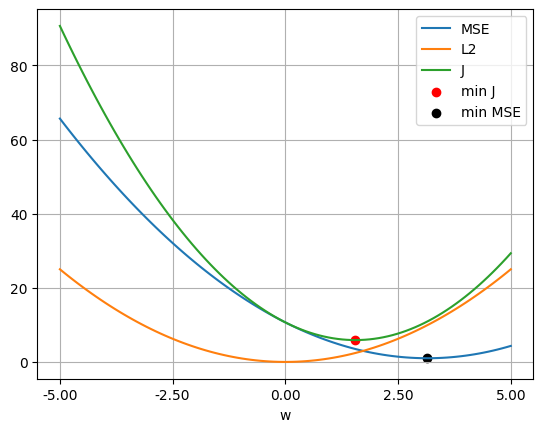

In [22]:
w_values = np.linspace(-5, 5, 100)
mss_values = np.array([mse_loss(w.reshape(-1, 1)) for w in w_values])
wd_values = np.array([weight_decay(LAMBDA2, w.reshape(-1, 1)) for w in w_values])
j_values = np.array([objective_mse(LAMBDA2, w.reshape(-1, 1)) for w in w_values])

plt.plot(w_values, mss_values, label='MSE')
plt.plot(w_values, wd_values, label='L2')
plt.plot(w_values, j_values, label='J')
plt.scatter(w_mse_l2.item(), objective_mse(LAMBDA2, w_mse_l2).item(), color='red', label='min J')
plt.scatter(w_ls.item(), mse_loss(w_ls).item(), color='black', label='min MSE')
plt.xticks(np.linspace(w_values[0], w_values[-1], 5))
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.2f}'))
plt.legend()
plt.xlabel('w')
plt.grid(True)
plt.show()

If we use $\lambda_{1} = \frac{m \lambda_{2}}{2}$, then
$$
\begin{align*}
J_{\text{MSE}}(\mathbf{w}) &= \frac{2}{m} J_\text{LS}(\mathbf{w}) \\
&= \frac{2}{m} \left(
    \frac{1}{2} \|\mathbf{Xw - y}\|^{2}_{2}
    + \frac{\lambda_{1}}{2}\|\mathbf{w}\|^{2}_{2}
\right) \\
&= \frac{1}{m} \|\mathbf{Xw - y}\|^{2}_{2}
+ \frac{\lambda_{1}}{m}\|\mathbf{w}\|^{2}_{2} \\
&= \frac{1}{m} \|\mathbf{Xw - y}\|^{2}_{2}
+ \frac{\lambda_{2}}{2}\|\mathbf{w}\|^{2}_{2} \\
&= \text{MSE}(\mathbf{w}) + \ell_{2}(\mathbf{w})
\end{align*}
$$
Therefore, least squares and MSE are the same when we scale the $\lambda$ value.

In [23]:
mape(
    objective_mse(2 * LAMBDA / M, w_ls), # remember that LAMBDA2 := 2 * LAMBDA / M
    objective_ls(LAMBDA, w_ls) * 2 / M
).item()

0.0

# Example with $\mathbf{w} \in \mathbb{R}^{2}$

In [25]:
from mpl_toolkits.mplot3d import Axes3D

In [26]:
X = np.random.randn(M, 2)
True_W_2 = np.array([[4.0], [1.5]])
Y = X @ True_W_2

X.shape, Y.shape

((1000, 2), (1000, 1))

In [27]:
LAMBDA3 = 1e3
w_2 = np.linalg.inv(X.T @ X + LAMBDA3 * np.identity(2)) @ X.T @ Y
w_2

array([[1.95216585],
       [0.71921752]])

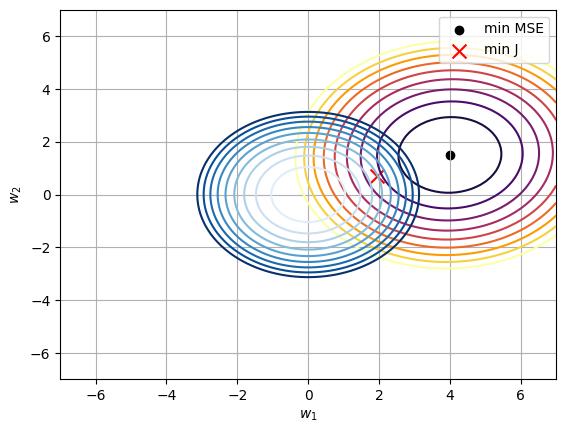

In [28]:
w1_values = np.linspace(-7, 7, 100)
w2_values = np.linspace(-7, 7, 100)
W1_values, W2_values = np.meshgrid(w1_values, w2_values)
mse_values = np.array([[mse_loss(np.array([[w1], [w2]])) for w1 in w1_values] for w2 in w2_values])
wd_values = np.array([[weight_decay(LAMBDA3, np.array([[w1], [w2]])) for w1 in w1_values] for w2 in w2_values])

plt.contour(W1_values, W2_values, mse_values, cmap='inferno',
            levels=np.linspace(np.min(mse_values) * 0.1, np.max(mse_values) * 0.1, 10))
plt.scatter(True_W_2[0, 0], True_W_2[1, 0], color='black', label='min MSE')
plt.contour(W1_values, W2_values, wd_values, cmap='Blues',
            levels=np.linspace(np.min(wd_values) * 0.1, np.max(wd_values) * 0.1, 10))
plt.scatter(w_2[0, 0], w_2[1, 0], marker='x', color='red', s=100, label='min J')
plt.xlim((-7, 7))
plt.ylim((-7, 7))
plt.grid(True)
plt.xlabel('$w_{1}$')
plt.ylabel('$w_{2}$')
plt.legend()
plt.show()

We can see that both functions have an oval shape because 
$w_{1}$ has a greater influence than $w_{2}$.

# What if $\mathbf{Y} \in \mathbb{R}^{m \times n_{1}}$?

MSE loss function
$$
\text{MSE}(\mathbf{W}) = \frac{1}{mn} \text{sum} \left( \left(
    \mathbf{XW - Y}
\right)^{2} \right)
$$
where $\mathbf{A}^{2} = \mathbf{A} \odot \mathbf{A}$.

weight decay function
$$
\ell_{2}(\mathbf{W}) = \frac{\lambda}{2} \text{sum} \left(
    \mathbf{W}^{2}
\right)
$$

Our objetive function
$$
J(\mathbf{W}) = \text{MSE}(\mathbf{W}) + \ell_{2}(\mathbf{W})
$$

the gradient of $J$
$$
\nabla_{\mathbf{W}} J = \frac{2}{mn} \mathbf{X}^{\top} \left(
    \mathbf{XW - Y}
\right) + \lambda \mathbf{W}
$$

then, its closed form
$$
\mathbf{W} = \frac{2}{mn} \left(
    \frac{2}{mn} \mathbf{X^{\top} X} + \lambda \boldsymbol{I}
\right)^{-1} \mathbf{X^{\top} Y}
$$

if we apply $\lambda \leftarrow \frac{2}{mn} \lambda$, therefore
$$
\mathbf{W} = \left(
    \mathbf{X^{\top} X} + \lambda \boldsymbol{I}
\right)^{-1} \mathbf{X^{\top} Y}
$$